In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
import sklearn.svm as svm
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.externals import joblib
from lesson_functions import *

In [2]:
# Load the training validation and test data
data_file = 'data.p'
with open(data_file, mode='rb') as f:
    data = pickle.load(f)
cars_train = data['cars_train']
cars_val   = data['cars_val']
cars_test  = data['cars_test']
notcars_train = data['notcars_train']
notcars_val   = data['notcars_val']
notcars_test  = data['notcars_test']

In [3]:
#helper function to extract features from files

def get_features(files, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    for file in files:
        
        img = mpimg.imread(file)
        img_features = single_img_features(img, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        
        features.append(img_features)
    return features

In [4]:
color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size = (16, 16)
hist_bins = 32
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_feat = True
hist_feat = True
hog_feat = True

t=time.time()
cars_train_feat = get_features(cars_train,color_space, spatial_size,hist_bins, orient, 
                               pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)
cars_val_feat = get_features(cars_val,color_space, spatial_size,hist_bins, orient, 
                               pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)
cars_test_feat = get_features(cars_test,color_space, spatial_size,hist_bins, orient, 
                               pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)

notcars_train_feat = get_features(notcars_train,color_space, spatial_size,hist_bins, orient, 
                               pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)
notcars_val_feat = get_features(notcars_val,color_space, spatial_size,hist_bins, orient, 
                               pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)
notcars_test_feat = get_features(notcars_test,color_space, spatial_size,hist_bins, orient, 
                               pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG,spatial and color features...')

60.68 Seconds to extract HOG,spatial and color features...


In [5]:
# Create an array stack of feature vectors
X = np.vstack((cars_train_feat,cars_val_feat,cars_test_feat,
               notcars_train_feat,notcars_val_feat,notcars_test_feat)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

In [6]:
cars_ntrain=len(cars_train_feat)
cars_nval=len(cars_val_feat)
cars_ntest=len(cars_test_feat)
ncars_ntrain=len(notcars_train_feat)
ncars_nval=len(notcars_val_feat)
ncars_ntest=len(notcars_test_feat)

i1 = cars_ntrain
i2 = i1 + cars_nval
i3 = i2 + cars_ntest
i4 = i3 + ncars_ntrain
i5 = i4 + ncars_nval

cars_train_feat,cars_val_feat,cars_test_feat = scaled_X[:i1],scaled_X[i1:i2],scaled_X[i2:i3]
notcars_train_feat,notcars_val_feat,notcars_test_feat = scaled_X[i3:i4],scaled_X[i4:i5],scaled_X[i5:]

y_train = np.hstack((np.ones(cars_ntrain), np.zeros(ncars_ntrain)))
y_val = np.hstack((np.ones(cars_nval), np.zeros(ncars_nval)))
y_test = np.hstack((np.ones(cars_ntest), np.zeros(ncars_ntest)))

X_train = np.vstack((scaled_X[:i1],scaled_X[i3:i4]))
X_val = np.vstack((scaled_X[i1:i2],scaled_X[i4:i5]))
X_test = np.vstack((scaled_X[i2:i3],scaled_X[i5:]))

X_train,y_train = shuffle(X_train,y_train,random_state=42)
X_val,y_val = shuffle(X_val,y_val,random_state=42)
X_test,y_test = shuffle(X_test,y_test,random_state=42)

In [7]:
print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()

# use of the rbf kernel improves the accuracy by about another percent, 
# but increases the prediction time up to 1.7s(!) for 100 labels. Too slow.
#svc = svm.SVC(kernel='rbf')

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Validation Accuracy of SVC = ', round(svc.score(X_val, y_val), 4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 100
print('My SVC predicts: ', svc.predict(X_val[0:n_predict]))
print('For these',n_predict, 'labels: ', y_val[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6156
13.25 Seconds to train SVC...
Validation Accuracy of SVC =  0.9837
Test Accuracy of SVC =  0.9859
My SVC predicts:  [ 1.  0.  0.  1.  0.  1.  0.  0.  0.  0.  1.  1.  1.  1.  0.  0.  0.  1.
  0.  1.  0.  1.  0.  1.  0.  1.  1.  1.  0.  0.  0.  1.  0.  1.  0.  1.
  1.  1.  1.  0.  0.  0.  0.  1.  1.  1.  1.  1.  0.  1.  1.  0.  1.  0.
  1.  0.  1.  1.  1.  0.  0.  1.  1.  0.  1.  1.  1.  1.  0.  1.  1.  0.
  0.  1.  0.  1.  0.  1.  1.  1.  0.  1.  0.  1.  0.  1.  1.  1.  0.  0.
  0.  0.  0.  1.  1.  0.  1.  1.  0.  0.]
For these 100 labels:  [ 1.  0.  0.  1.  0.  1.  0.  0.  0.  0.  1.  1.  1.  1.  0.  0.  0.  0.
  0.  1.  0.  1.  0.  1.  0.  1.  1.  1.  0.  0.  0.  1.  0.  1.  0.  1.
  1.  1.  1.  0.  0.  0.  0.  1.  1.  1.  1.  1.  0.  1.  1.  0.  1.  0.
  0.  0.  1.  1.  1.  0.  0.  1.  1.  0.  1.  1.  1.  1.  0.  1.  1.  0.
  0.  1.  0.  1.  0.  1.  1.  1.  0.  1.  0.  1.  0.  1.  1.  1.  0.  0.

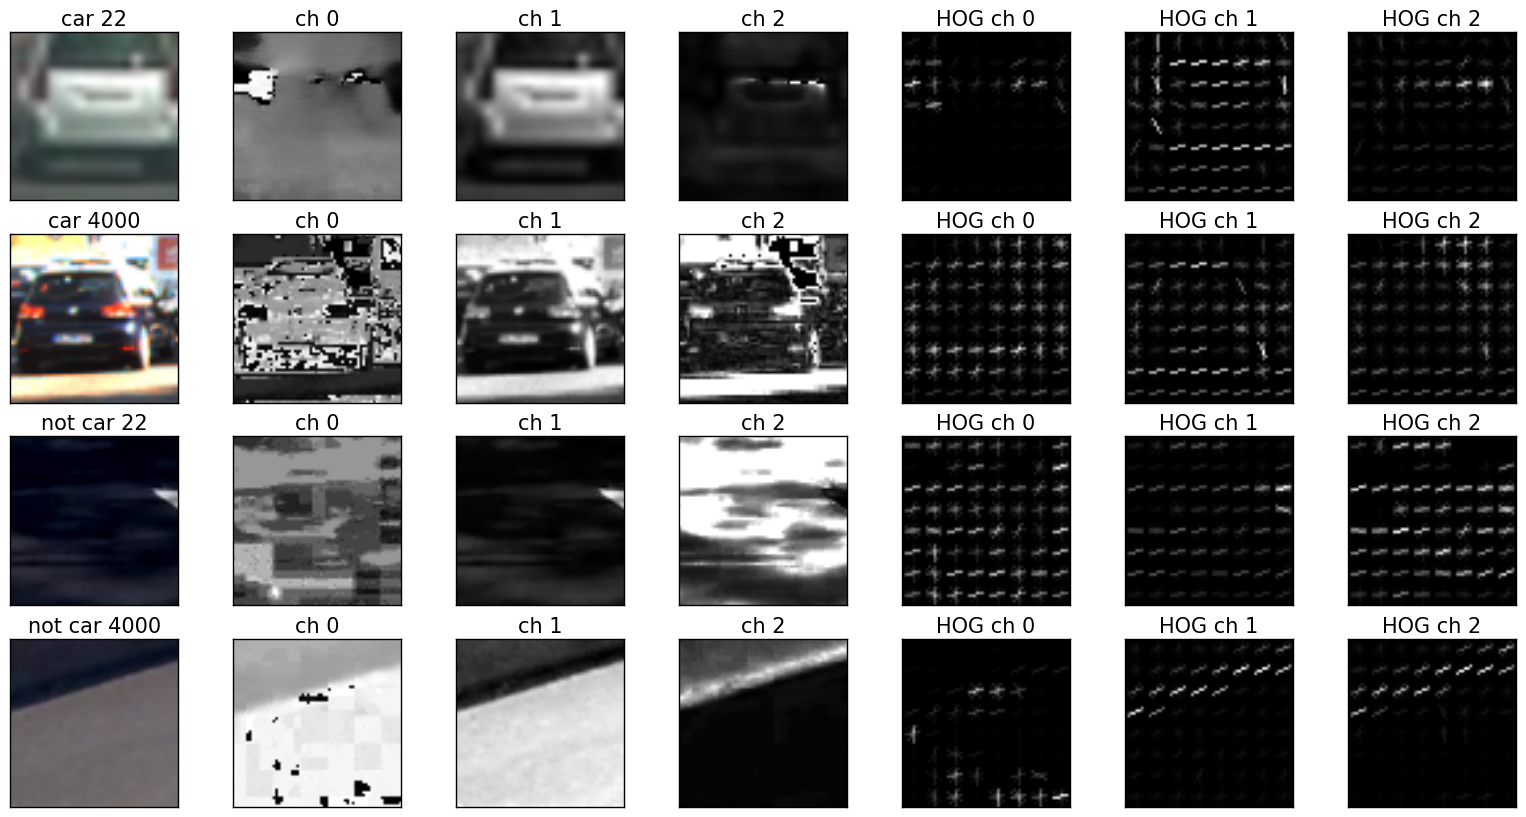

In [18]:
font_size=15
f, axarr = plt.subplots(4, 7,figsize=(20,10))
f.subplots_adjust(hspace=0.2, wspace=0.05)
colorspace = cv2.COLOR_RGB2HLS
#colorspace=cv2.COLOR_RGB2HSV
#colorspace=cv2.COLOR_RGB2YCrCb

i1,i2=22,4000

for ind,j in enumerate([i1,i2]):
    image = plt.imread(cars_train[j])
    feature_image = cv2.cvtColor(image, colorspace)

    axarr[ind,0].imshow(image)
    axarr[ind,0].set_xticks([])
    axarr[ind,0].set_yticks([])
    title = "car {0}".format(j)
    axarr[ind,0].set_title(title, fontsize=font_size)

    for channel in range(3):        
        axarr[ind,channel+1].imshow(feature_image[:,:,channel],cmap='gray')
        title = "ch {0}".format(channel)
        axarr[ind,channel+1].set_title(title, fontsize=font_size)
        axarr[ind,channel+1].set_xticks([])
        axarr[ind,channel+1].set_yticks([])    
    
    for channel in range(3):
        features,hog_image = get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, 
                                              cell_per_block, vis=True, feature_vec=True)
        axarr[ind,channel+4].imshow(hog_image,cmap='gray')
        title = "HOG ch {0}".format(channel)
        axarr[ind,channel+4].set_title(title, fontsize=font_size)
        axarr[ind,channel+4].set_xticks([])
        axarr[ind,channel+4].set_yticks([])
        
        
for indn,j in enumerate([i1,i2]):
    ind=indn+2
    image = plt.imread(notcars_train[j])
    feature_image = cv2.cvtColor(image, colorspace)

    axarr[ind,0].imshow(image)
    axarr[ind,0].set_xticks([])
    axarr[ind,0].set_yticks([])
    title = "not car {0}".format(j)
    axarr[ind,0].set_title(title, fontsize=font_size)

    for channel in range(3):        
        axarr[ind,channel+1].imshow(feature_image[:,:,channel],cmap='gray')
        title = "ch {0}".format(channel)
        axarr[ind,channel+1].set_title(title, fontsize=font_size)
        axarr[ind,channel+1].set_xticks([])
        axarr[ind,channel+1].set_yticks([])        
    
    for channel in range(3):
        features,hog_image = get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, 
                                              cell_per_block, vis=True, feature_vec=True)
        axarr[ind,channel+4].imshow(hog_image,cmap='gray')
        title = "HOG ch {0}".format(channel)
        axarr[ind,channel+4].set_title(title, fontsize=font_size)
        axarr[ind,channel+4].set_xticks([])
        axarr[ind,channel+4].set_yticks([])
        
              
plt.show()
#plt.savefig('./images/HOG_features_HLS.png')
#plt.savefig('./images/HOG_features_YCrCb.png')

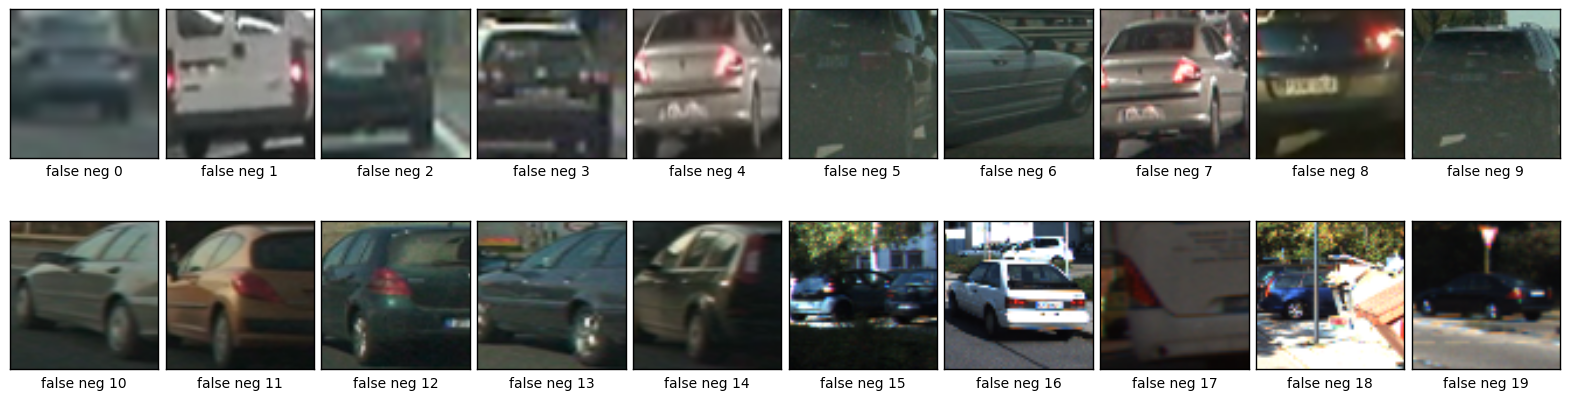

number of misclassified car images 20


In [9]:
# plot false positives/negatives
font_size=15
preds = svc.predict(cars_val_feat)
misclassifieds = np.array(preds != np.ones(cars_nval))
inds = np.where(preds != np.ones(cars_nval))
inds = np.ravel(inds)
misclassifieds = [ cars_val[i] for i in inds]
    
fig, axes = plt.subplots(2,10,figsize=(20,5))
fig.subplots_adjust(hspace=0.2, wspace=0.05)
    
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(misclassifieds[i]))
    xlabel = "false neg {0}".format(i)
    ax.set_xlabel(xlabel)
    ax.set_xticks([])
    ax.set_yticks([])     
    

plt.show()
print('number of misclassified car images',len(misclassifieds))
#plt.savefig('./images/false_negatives.png')

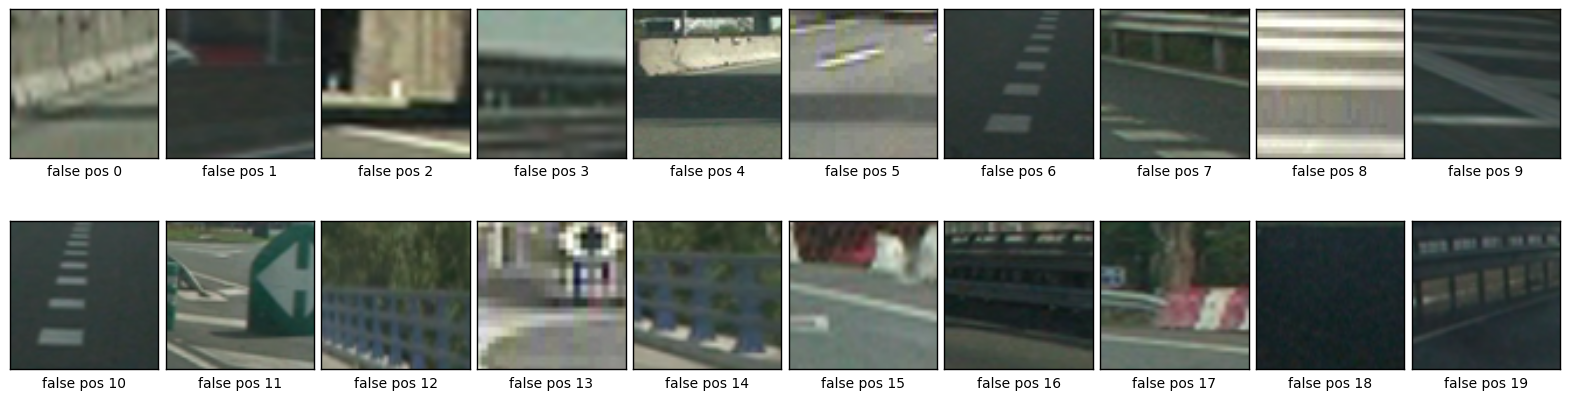

number of misclassified notcar images 38


In [10]:
fig, axes = plt.subplots(2,10,figsize=(20,5))
fig.subplots_adjust(hspace=0.2, wspace=0.05)
    
preds = svc.predict(notcars_val_feat)
inds = np.where(preds != np.zeros(ncars_nval))
inds = np.ravel(inds)
misclassifieds = [ notcars_val[i] for i in inds]

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(misclassifieds[i]))
    xlabel = "false pos {0}".format(i)
    ax.set_xlabel(xlabel)
    ax.set_xticks([])
    ax.set_yticks([])     

plt.show()
print('number of misclassified notcar images',len(misclassifieds))
#plt.savefig('./images/false_positives.png')


In [11]:
# Save the data for easy access
pickle_file = 'ProcessedData.p'
print('Saving data to pickle file...')
try:
    with open(pickle_file, 'wb') as pfile:
        pickle.dump(
            {
                'X_train': X_train,
                'X_val': X_val,
                'X_test': X_test,
                'y_train': y_train,
                'y_val': y_val,
                'y_test': y_test                
            },
            pfile, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise
    
print('Data cached in pickle file.')


pickle_file = 'ClassifierData.p'
print('Saving data to pickle file...')
try:
    with open(pickle_file, 'wb') as pfile:
        pickle.dump(
            {   'svc':svc, 
                'X_scaler': X_scaler,
                'color_space': color_space,
                'spatial_size': spatial_size,
                'hist_bins': hist_bins,
                'orient': orient,
                'pix_per_cell': pix_per_cell,
                'cell_per_block': cell_per_block,
                'hog_channel': hog_channel,
                'spatial_feat': spatial_feat,
                'hist_feat': hist_feat,
                'hog_feat':hog_feat
            },
            pfile, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

print('Data cached in pickle file.')


Saving data to pickle file...
Data cached in pickle file.
Saving data to pickle file...
Data cached in pickle file.
